# Retrieve Most Recent Movie Data from TMDB Database (2018-2022)

In [133]:
#Imports
import os, time, json
import tmdbsimple as tmdb
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm_notebook
from matplotlib.ticker import FuncFormatter
import numpy as np
import scipy.stats as stats

In [95]:
with open('/Users/kellyji/.secret/tmdb_api.json','r') as f:
    login=json.load(f)

login.keys()

dict_keys(['api-key', 'API Read Access Token'])

In [96]:
#Login TMDB API with credientials 
import tmdbsimple as tmdb
tmdb.API_KEY = login['api-key']

In [97]:
# Load data
basics=pd.read_csv('Data/basics.csv')
basics.head()

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
0,tt0035423,movie,Kate & Leopold,Kate & Leopold,0,2001.0,NaN,118,"Comedy,Fantasy,Romance"
1,tt0062336,movie,The Tango of the Widower and Its Distorting Mi...,El tango del viudo y su espejo deformante,0,2020.0,NaN,70,Drama
2,tt0069049,movie,The Other Side of the Wind,The Other Side of the Wind,0,2018.0,NaN,122,Drama
3,tt0088751,movie,The Naked Monster,The Naked Monster,0,2005.0,NaN,100,"Comedy,Horror,Sci-Fi"
4,tt0096056,movie,Crime and Punishment,Crime and Punishment,0,2002.0,NaN,126,Drama


In [98]:
FOLDER="Data/Hypothesis_Testing_data/"
os.makedirs(FOLDER, exist_ok=True)
os.listdir(FOLDER)

['final_tmdb_data_2018.csv.gz',
 'final_tmdb_data_2022.csv.gz',
 'final_tmdb_data_2020.csv.gz',
 'tmdb_api_results_2020.json',
 'tmdb_api_results_2021.json',
 'tmdb_api_results_2022.json',
 'tmdb_api_results_2018.json',
 'final_tmdb_data_2019.csv.gz',
 'final_tmdb_data_2021.csv.gz',
 'tmdb_api_results_2019.json',
 '.ipynb_checkpoints']

**Load customized functions**

In [4]:
def get_movie_with_rating(movie_id):
    movie = tmdb.Movies(movie_id)
    
    movie_info = movie.info()
    releases = movie.releases()
    
    for c in releases['countries']:
        if c['iso_3166_1' ] =='US':
            movie_info['certification'] = c['certification']
    return movie_info


def write_json(new_data, filename): 
    """Appends a list of records (new_data) to a json file (filename). 
    Adapted from: https://www.geeksforgeeks.org/append-to-json-file-using-python/"""  
    
    with open(filename,'r+') as file:
        file_data = json.load(file)
        if (type(new_data) == list) & (type(file_data) == list):
            file_data.extend(new_data)
        else:
             file_data.append(new_data)
        file.seek(0)
        json.dump(file_data, file)

**Decided to get the most recent 5-year movie data**

In [32]:
YEARS_TO_GET=list(range(2018, 2023))

In [33]:
for YEAR in tqdm_notebook(YEARS_TO_GET, desc='YEARS', position=0):
    JSON_FILE_YEAR = f'{FOLDER}tmdb_api_results_{YEAR}.json'
    file_exists = os.path.isfile(JSON_FILE_YEAR)

    if file_exists == False:
        print(f'Creating{JSON_FILE_YEAR} for API results for year = {YEAR}.')
        with open (JSON_FILE_YEAR, 'w') as f:
            json.dump([{'imdb_id':0}],f)

    else:
        print(f'The file {JSON_FILE_YEAR} already exists.')

    df_year = basics.loc[basics['startYear'] == YEAR].copy()
    movie_ids = df_year['tconst']
        
        # Create an empty list to store movie information
    movie_info_list = []
    errors=[]    
        # Iterate over movie IDs for the current year
    for movie_id in tqdm_notebook(movie_ids, f'Movies from {YEAR}'):
        try:
            temp = get_movie_with_rating(movie_id)
            movie_info_list.append(temp)
            time.sleep(0.02)
        except Exception as e:
            errors.append([movie_id, e])
        
        # Write the movie information to the JSON file
    write_json(movie_info_list, JSON_FILE_YEAR)

    final_year_df2 = pd.read_json(JSON_FILE_YEAR)
    csv_fname = f'{FOLDER}final_tmdb_data_{YEAR}.csv.gz'
    final_year_df2.to_csv(csv_fname, compression='gzip', index=False)

YEARS:   0%|          | 0/5 [00:00<?, ?it/s]

The file Data/Hypothesis_Testing_data/tmdb_api_results_2018.json already exists.


Movies from 2018:   0%|          | 0/5785 [00:00<?, ?it/s]

CreatingData/Hypothesis_Testing_data/tmdb_api_results_2019.json for API results for year = 2019.


Movies from 2019:   0%|          | 0/5877 [00:00<?, ?it/s]

CreatingData/Hypothesis_Testing_data/tmdb_api_results_2020.json for API results for year = 2020.


Movies from 2020:   0%|          | 0/5010 [00:00<?, ?it/s]

CreatingData/Hypothesis_Testing_data/tmdb_api_results_2021.json for API results for year = 2021.


Movies from 2021:   0%|          | 0/5163 [00:00<?, ?it/s]

CreatingData/Hypothesis_Testing_data/tmdb_api_results_2022.json for API results for year = 2022.


Movies from 2022:   0%|          | 0/5073 [00:00<?, ?it/s]

## Combine All API results

In [74]:
import glob
tmdb_files = sorted(glob.glob('Data/Hypothesis_Testing_data/final_tmdb_data*.csv.gz'))
tmdb_files

['Data/Hypothesis_Testing_data/final_tmdb_data_2018.csv.gz',
 'Data/Hypothesis_Testing_data/final_tmdb_data_2019.csv.gz',
 'Data/Hypothesis_Testing_data/final_tmdb_data_2020.csv.gz',
 'Data/Hypothesis_Testing_data/final_tmdb_data_2021.csv.gz',
 'Data/Hypothesis_Testing_data/final_tmdb_data_2022.csv.gz']

In [75]:
# Combine with concat to load all files
df=pd.concat([pd.read_csv(f, lineterminator='\n') for f in tmdb_files])

In [99]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21638 entries, 0 to 3951
Data columns (total 26 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   imdb_id                21638 non-null  object 
 1   adult                  21633 non-null  float64
 2   backdrop_path          17039 non-null  object 
 3   belongs_to_collection  1307 non-null   object 
 4   budget                 21633 non-null  float64
 5   genres                 21633 non-null  object 
 6   homepage               6069 non-null   object 
 7   id                     21633 non-null  float64
 8   original_language      21633 non-null  object 
 9   original_title         21633 non-null  object 
 10  overview               21313 non-null  object 
 11  popularity             21633 non-null  float64
 12  poster_path            21219 non-null  object 
 13  production_companies   21633 non-null  object 
 14  production_countries   21633 non-null  object 
 15  rel

In [100]:
fname = f'Data/tmdb_results_combined2018_2022.csv.gz'
df.to_csv(fname, compression='gzip',index=False)

In [101]:
df.head(3)

,imdb_id,adult,backdrop_path,belongs_to_collection,budget,genres,homepage,id,original_language,original_title,...,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,certification
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,tt0069049,0.0,/wXUcSJG6dqNKgIRgqYqX98UA1wz.jpg,NaN,12000000.0,"[{'id': 18, 'name': 'Drama'}]",https://www.netflix.com/title/80085566,299782.0,en,The Other Side of the Wind,...,0.0,122.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,40 years in the making.,The Other Side of the Wind,0.0,6.7,195.0,R
2,tt0192528,0.0,/gkBxjhtVEqgxOiRwRfWw1j7ez6K.jpg,NaN,5000000.0,"[{'id': 18, 'name': 'Drama'}]",NaN,567662.0,en,Reverse Heaven,...,0.0,104.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Heaven's in trouble and there's one man who ca...,Heaven & Hell,0.0,6.0,7.0,NaN


## Hypothesis Testing

### Does the MPAA rating of a movie (G/PG/PG-13/R) affect how much revenue the movie generates?

**State the Hypothesis and Null Hypothesis**

- Null Hypothesis: The MPAA ratings of a movie have NO effect on revenue the movie generates.
- Alternative Hypothesis: The MPAA ratings of a movie affect the revenue the movie generates.

In [102]:
# Droping row with nulls in Certification and Revenue
df_h=df.dropna(subset=['revenue','certification'])

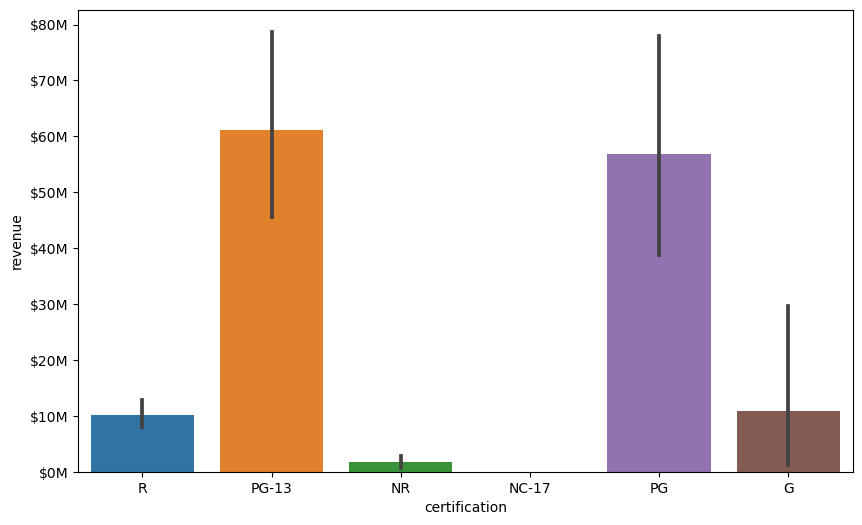

In [103]:
fi,ax = plt.subplots(figsize=(10,6))
sns.barplot(data=df_h,x='certification',y='revenue')
formatter = FuncFormatter(lambda x, _: f"${int(x / 1e6):,}M")
ax.yaxis.set_major_formatter(formatter);

- Date type: Numeric
- More than 2 groups/samples (6 groups)

**Choose to use ANOVA for hypothesis testing**

Assumptions of ANOVA:

- No significant outliers
- Equal variance
- Normality

### Testing ANOVA Assumptions

In [104]:
# Create groups dicts
groups = {}

# Loop through all unique categories
for certification in df_h['certification'].unique():
    data = df_h.loc[df_h['certification']==certification,'revenue'].copy()
    groups[certification]=data

groups.keys()

dict_keys(['R', 'PG-13', 'NR', 'NC-17', 'PG', 'G'])

#### Check for Outliers

In [105]:
groups_clean= {}

for group,data in groups.items():
    outliers=np.abs(stats.zscore(data))>3
    n_outliers=np.sum(outliers)

    print(f"- For {group}, there were {n_outliers} outliers removed.")
    clean_data = data[~outliers]
    groups_clean[group] = clean_data

groups_clean.keys()


- For R, there were 31 outliers removed.
- For PG-13, there were 21 outliers removed.
- For NR, there were 8 outliers removed.
- For NC-17, there were 1 outliers removed.
- For PG, there were 6 outliers removed.
- For G, there were 1 outliers removed.


dict_keys(['R', 'PG-13', 'NR', 'NC-17', 'PG', 'G'])

#### Check for Normalityn

In [106]:
norm_results=[]
for group, data in groups_clean.items():
    stat,p=stats.normaltest(data)
    norm_results.append({'group':group,'n':len(data),'p':p,'test stat':stat,'sig?':p<0.05})
norm_results_df=pd.DataFrame(norm_results)
norm_results_df

,group,n,p,test stat,sig?
0,R,1409,2.188625e-299,1375.379339,True
1,PG-13,708,2.130685e-141,647.816109,True
2,NR,1221,0.000000e+00,2062.285611,True
3,NC-17,50,4.312673e-19,84.575118,True
4,PG,385,2.132682e-65,297.821302,True
5,G,133,6.379229e-53,240.367925,True


- None of the groups are normally distributed, BUT our groups are greater than n=15 so we can safely disregard the assumption of normality.

#### Test for Equal Variance

In [107]:
res = stats.levene(*groups_clean.values())
res

LeveneResult(statistic=53.07411328517931, pvalue=1.8810824223992405e-53)

- The null hypothiese of the Levene's test is that the samples DO have equal variance
    - Therefore, our significant p-value indicates that we do NOT have equal varince
    - Therefore we will run the Kruskal-Wallis test instead of the ANOVA test.

### Final Hypothiese Teste

In [111]:
res = stats.kruskal(*groups_clean.values())
res

KruskalResult(statistic=339.5858085386635, pvalue=3.0545885357113232e-71)

In [112]:
res.pvalue<0.05

True

**Our p-value is less than alpha 0.05, so in conclusion the MPAA ratings of a movie DOES affect the revenue the movie generates.**

### Do movies that are over 2.5 hours(150mins) long earn more revenue than movies that are 1.5 hours (90mins)long (or less)?

**State the Hypothesis and Null Hypothesis**

- Null Hypothesis: Movies over 150 minutes earn the same revenue as the movies that are less than 90 minutes long.
- Alternative Hypothesis: There is a dfferent in revenue between movies that are over 150 minutes and movies that are less than 90 minutes long.

In [134]:
# Dropping rows with null values in 'revenue' and 'runtime' columns.
df_2=df.dropna(subset=['revenue', 'runtime'])

In [135]:
# Create df for 2 groups
movie_over=df_2.loc[df_2['runtime']>150].copy()
movie_less=df_2.loc[df_2['runtime']<90].copy()
movie_150=movie_over['revenue']
movie_90=movie_less['revenue']

In [154]:
combined_df = pd.concat([movie_over, movie_less], ignore_index=True)
combined_df['movie_over150']=combined_df['runtime']>150

In [156]:
combined_df['movie_over150'].value_counts()

False    7969
True      480
Name: movie_over150, dtype: int64

In [138]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8449 entries, 0 to 8448
Data columns (total 27 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   imdb_id                8449 non-null   object 
 1   adult                  8449 non-null   float64
 2   backdrop_path          5701 non-null   object 
 3   belongs_to_collection  426 non-null    object 
 4   budget                 8449 non-null   float64
 5   genres                 8449 non-null   object 
 6   homepage               1963 non-null   object 
 7   id                     8449 non-null   float64
 8   original_language      8449 non-null   object 
 9   original_title         8449 non-null   object 
 10  overview               8192 non-null   object 
 11  popularity             8449 non-null   float64
 12  poster_path            8182 non-null   object 
 13  production_companies   8449 non-null   object 
 14  production_countries   8449 non-null   object 
 15  rele

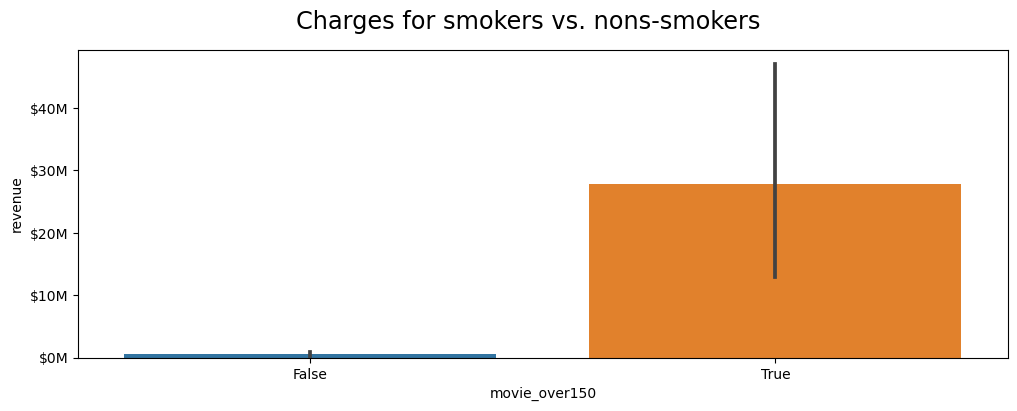

In [157]:
## Visualizing Sample means
fig, ax = plt.subplots(figsize= (12,4))
## Barplot
sns.barplot(data=combined_df, x='movie_over150',y='revenue')
fig.suptitle('Charges for smokers vs. nons-smokers',fontsize='xx-large')
formatter = FuncFormatter(lambda x, _: f"${int(x / 1e6):,}M")
ax.yaxis.set_major_formatter(formatter);

- Date type: Numeric
- 2 groups/samples

**Choose to use 2 sample ttest for hypothesis testing**

Assumptions of 2-sample T-Test:

- No significant outliers
- Normality
- Equal Variance

### Testing 2-sample T-test Assumptions

#### Check for Outliers

In [158]:
#Find and remove outliers for movies over 150mins
zscores=stats.zscore(movie_150)
outliers=abs(zscores)>3
np.sum(outliers)

7

In [159]:
movie_150=movie_150[~outliers]

In [160]:
#Find and remove outliers for movies less than 90mins
zscores=stats.zscore(movie_90)
outliers=abs(zscores)>3
np.sum(outliers)

21

In [161]:
movie_90=movie_90[~outliers]

#### Check for Normality

In [163]:
# Normality check for movies over 150mins
norm_res=stats.normaltest(movie_150)
norm_res

NormaltestResult(statistic=650.5233787623582, pvalue=5.503552671466178e-142)

In [164]:
norm_res.pvalue<0.05

True

- Distribution of movies over 150mins is not normal.

In [165]:
# Normality check for movies less than 90mins
norm_res=stats.normaltest(movie_90)
norm_res

NormaltestResult(statistic=17724.297558855837, pvalue=0.0)

In [166]:
norm_res.pvalue<0.05

True

- Distribution of movies less than 90mins is not normal.

**Althought the distributions of the two groups are not normal, we can enough sample size in both groups to satisfy the assumption**

#### Check for Equal Variance

In [167]:
result = stats.levene(movie_150,movie_90)
result

LeveneResult(statistic=271.49476733379606, pvalue=4.641256303171335e-60)

In [168]:
result.pvalue<0.05

True

- The null hypothesis of the Levene's test is that the samples DO have equal variance.

- Therefore, our significant p-value indicates that we do NOT have equal varaince.
- Therefore, we will run the Welch's t-test instead of the default (for scipy's ttest_ind change the equal_var argument to False)

### Final Hypothiese Teste

In [170]:
# Since not equal variances, set equal_var =False
result = stats.ttest_ind(movie_150,movie_90,equal_var=False)
result

Ttest_indResult(statistic=4.03307055129242, pvalue=6.41912059907918e-05)

In [171]:
result.pvalue<0.05

True

- Our Welch's T-Test returns a p-value < .05 therefore we can reject the null hypothesis and support the alternative hypothesis that There is a significant difference in revenue for movies that are over 150 mins and movies that are less than 90 mins.
- In order to know which group has the higher or lower revenue, we look at the actual means of our final groups.

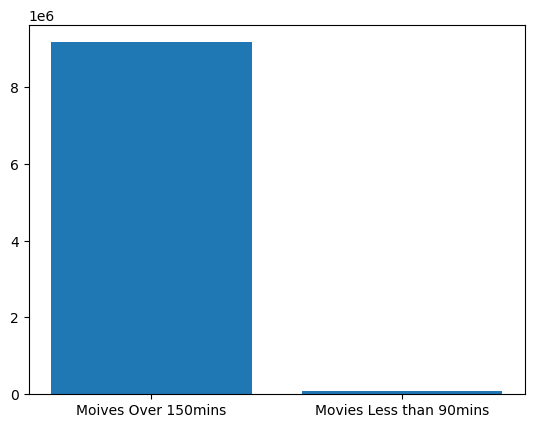

In [172]:
plt.bar(['Moives Over 150mins','Movies Less than 90mins'],[movie_150.mean(),movie_90.mean()]);

**Movies over 150 minutes have higher average revenue than movies that are less than 90 minutes.**